# Preprocess MovieLens-20M 

In [2]:
import datetime
import os

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import scipy.sparse

#import seaborn as sns
#sns.set(context="paper", font_scale=1.5, rc={"lines.linewidth": 2}, font='DejaVu Serif')

In [3]:
DATA_DIR = '/Users/appry001/Data/ml-25m/'

In [4]:
def timestamp_to_date(timestamp):
    return datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

In [5]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'ratings.csv'), header=0)

In [6]:
# binarize the data (only keep ratings >= 4)
raw_data = raw_data[raw_data['rating'] > 3.5]

In [7]:
# sort the raw data accorindg to timestamp
raw_data = raw_data.sort_values(by=['timestamp'])

In [8]:
raw_data

,userId,movieId,rating,timestamp
326767,2262,47,5.0,789652009
16940352,109832,7,5.0,822873600
16940375,109832,60,4.0,822873600
16940372,109832,50,5.0,822873600
16940371,109832,48,4.0,822873600
...,...,...,...,...
13207868,85523,109487,4.5,1574327445
13207880,85523,168252,4.0,1574327479
13207893,85523,204704,4.0,1574327533
1284464,8642,122914,4.0,1574327549


In [9]:
tstamp = np.array(raw_data['timestamp'])

In [10]:
print("Time span of the dataset: From %s to %s" % 
      (timestamp_to_date(np.min(tstamp)), timestamp_to_date(np.max(tstamp))))

Time span of the dataset: From 1995-01-09 06:46:49 to 2019-11-21 04:15:03


In [11]:
# apparently the timestamps are ordered, check to make sure

for i in range(tstamp.size - 1):
    if tstamp[i] > tstamp[i + 1]:
        print("not ordered")
else:
    print('confirmed timestamps are ordered')

confirmed timestamps are ordered


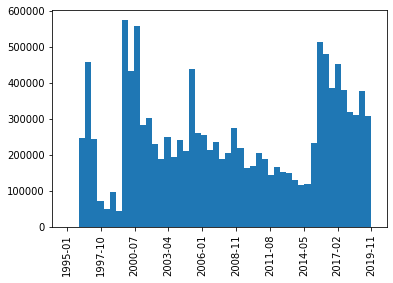

In [12]:
plt.hist(tstamp, bins=50)
xticks = np.linspace(tstamp[0], tstamp[-1], 10)
plt.xticks(xticks, map(lambda x: timestamp_to_date(x)[:7], xticks), rotation=90)
pass

Now we select the data from 1995-01-01 to the last day as the dataset (i.e., all the dataset)

In [13]:
import time
start_t = time.mktime(datetime.datetime.strptime("1995-01-01", "%Y-%m-%d").timetuple())

In [14]:
raw_data = raw_data[raw_data['timestamp'] >= start_t]

In [15]:
# first 80% as training/vald
tr_vd_raw_data = raw_data[:int(0.8 * raw_data.shape[0])]

In [19]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=True)
    count = playcount_groupbyid.size()
    return count

In [20]:
def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for songs which were listened to by at least min_sc users. 
    if min_sc > 0:
        songcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(songcount.index[songcount >= min_sc])]
    
    # Only keep the triplets for users who listened to at least min_uc songs
    # After doing this, some of the songs will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and songcount after filtering
    usercount, songcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, songcount

In [21]:
tr_vd_raw_data, user_activity, item_popularity = filter_triplets(tr_vd_raw_data)

In [23]:
# ml-20m
# After filtering, there are 7992863 watching events from 111148 users and 11711 movies (sparsity: 0.614%)
# ml-25m
sparsity = 1. * tr_vd_raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])
print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (tr_vd_raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 9957658 watching events from 135902 users and 24657 movies (sparsity: 0.297%)


In [24]:
unique_uid = user_activity.index
unique_sid = item_popularity.index

In [25]:
song2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
user2id = dict((uid, i) for (i, uid) in enumerate(unique_uid))

In [27]:
with open(os.path.join(DATA_DIR, 'pro', 'unique_uid.txt'), 'w') as f:
    for uid in unique_uid:
        f.write('%s\n' % uid)

In [28]:
with open(os.path.join(DATA_DIR, 'pro', 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

Split 12.5% (10% of the total ratings) as validation set

In [29]:
np.random.seed(13579)
n_ratings = tr_vd_raw_data.shape[0]
vad = np.random.choice(n_ratings, size=int(0.125 * n_ratings), replace=False)

In [30]:
vad_idx = np.zeros(n_ratings, dtype=bool)
vad_idx[vad] = True

vad_raw_data = tr_vd_raw_data[vad_idx]
train_raw_data = tr_vd_raw_data[~vad_idx]

Make sure there is no empty users/items

In [35]:
text = "\tTraining dataset users: {0}\n\tFull dataset users: {1}"
print(text.format(len(pd.unique(train_raw_data['userId'])), len(unique_uid)))

	Training dataset users: 135902
	Full dataset users: 135902


In [37]:
text = "\tTraining dataset movies: {0}\n\tFull dataset movies: {1}"
print(text.format(len(pd.unique(train_raw_data['movieId'])), len(unique_sid)))

	Training dataset movies: 23978
	Full dataset movies: 24657


In [38]:
train_sid = set(pd.unique(train_raw_data['movieId']))

In [39]:
left_sid = list()
for i, sid in enumerate(unique_sid):
    if sid not in train_sid:
        left_sid.append(sid)

In [40]:
move_idx = vad_raw_data['movieId'].isin(left_sid)

In [41]:
train_raw_data = train_raw_data.append(vad_raw_data[move_idx])
vad_raw_data = vad_raw_data[~move_idx]

In [42]:
text = "\tTraining dataset movies: {0}\n\tFull dataset movies: {1}"
print(text.format(len(pd.unique(train_raw_data['movieId'])), len(unique_sid)))

	Training dataset movies: 24657
	Full dataset movies: 24657


For test data, only keep the users and items that appear in the training/validation sets

In [43]:
test_raw_data = raw_data[int(0.8 * len(raw_data)):]

In [44]:
test_raw_data = test_raw_data[test_raw_data['movieId'].isin(unique_sid)]
test_raw_data = test_raw_data[test_raw_data['userId'].isin(unique_uid)]

In [45]:
# ml-20m 6993860 999003 207161
print(len(train_raw_data), len(vad_raw_data), len(test_raw_data))

8713678 1243980 227531


Basic data information: what's the timespan for train/test?

In [46]:
train_timestamp = np.asarray(tr_vd_raw_data['timestamp'])
print("train: from %s to %s" % (timestamp_to_date(train_timestamp[0]), 
                                timestamp_to_date(train_timestamp[-1])))

test_timestamp = np.asarray(test_raw_data['timestamp'])
print("test: from %s to %s" % (timestamp_to_date(test_timestamp[0]), 
                               timestamp_to_date(test_timestamp[-1])))

train: from 1995-01-09 06:46:49 to 2016-06-17 09:53:00
test: from 2016-06-17 09:56:52 to 2019-11-21 04:12:29


### Numerize the data into (timestamp, user_index, item_index) format

In [51]:
def numerize(tp):
    uid = map(lambda x: user2id[x], tp['userId'])
    sid = map(lambda x: song2id[x], tp['movieId'])
    tp['uid'] = list(uid)
    tp['sid'] = list(sid)
    return tp[['timestamp', 'uid', 'sid']]

In [52]:
train_data = numerize(train_raw_data)
train_data.to_csv(os.path.join(DATA_DIR, 'pro', 'train.csv'), index=False)

In [53]:
vad_data = numerize(vad_raw_data)
vad_data.to_csv(os.path.join(DATA_DIR, 'pro', 'validation.csv'), index=False)

In [54]:
test_data = numerize(test_raw_data)
test_data.to_csv(os.path.join(DATA_DIR, 'pro', 'test.csv'), index=False)